# Similarity Modeling 1/2: Recognizing Swedish Chef in Audio with Deep Learning  

#### Student
Matthias Hofmaier (11944050)
#### Timesheet
2022/10/10 - 2022/10/10    | Watch lecture videos and write abstracts

2022/11/23 | 16:30 - 18:00 | Setup Jupyter environment and project          

2022/11/23 | 18:00 - 19:30 | Exploration and preparation of ground truth

2022/11/23 | 19:30 - 20:30 | Research for potential implementation strategies

2022/11/24 | 09:00 - 11:30 | Video to audio conversion and spectrogram creation

2022/11/26 | 14:00 - 16:00 | Implemented CNN training pipeline

2022/11/27 | 10:00 - 11:00 | Team meeting

2022/12/03 | 13:00 - 16:30 | Setup COLAB and implement CNN training pipeline

2022/12/04 | 14:00 - 18:00 | Experiment with different CNN architectures

2022/12/04 | 19:00 - 20:00 | Team meeting

2022/12/20 | 14:00 - 20:00 | Experiment with different spectrogram snippet sizes

2022/12/27 | 09:00 - 16:00 | Develop CNN architecture and retrain model

2022/12/31 | 15:00 - 16:00 | Team meeting

2023/01/04 | 15:00 - 19:00 | Evaluation and documentation of the notebook

2023/01/05 | 08:00 - 10:00 | Summary notebook

## Google colab integration

In [1]:
# This code block enables this notebook to run on google colab.
try:
    from google.colab import drive

    print("Running in colab...\n===================")
    COLAB = True
    drive.mount("/content/gdrive")
    root_path = "gdrive/MyDrive/similarity-modeling"

except:
    print("=======================\nNOT running in colab...\n=======================")
    COLAB = False

Running in colab...
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Required libraries and installs
**We use Python 3.9**

In [2]:
if COLAB:
    !cat $root_path/notebooks/requirements-dl-audio.txt
    !pip install -r $root_path/notebooks/requirements-dl-audio.txt
else:
    !cat requirements-dl-audio.txt
    !pip install -r requirements-dl-audio.txt

pandas
numpy
opencv-python
librosa==0.9.2
tqdm
tensorflow==2.9.2
matplotlib==3.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**NOTE:** ffmpeg has to be installed on your device!
This can be done with one of the following commands:

In [3]:
#!brew install ffmpeg # MacOS (tested)
#!sudo apt install ffmpeg # Ubuntu (not tested)

For windows check: https://phoenixnap.com/kb/ffmpeg-windows

## Imports

In [4]:
import os

import cv2
import librosa
import librosa.display
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    average_precision_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from tqdm import tqdm

## Constants

In [5]:
if COLAB:
    DATA_PATH = os.path.join(root_path, "data")
else:
    DATA_PATH = "../data/"

GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "sim12-ground-truth-muppets")
VIDEO_PATH = os.path.join(DATA_PATH, "video")
PROCESSED_DATA_PATH = os.path.join(DATA_PATH, "processed")


RANDOM_STATE = 42

# 1. Data Preparation

## 1.1 Load ground truth data
The columns in the CSV files indicate at which frames Kermit, Waldorf & Statler, Pigs and/or the Danish chef are visually present (no prefix) or can be heared ("Audio_*").

In [6]:
gts = []
for fname in os.listdir(GROUND_TRUTH_PATH):
    if fname.startswith("GroundTruth"):
        df = pd.read_csv(os.path.join(GROUND_TRUTH_PATH, fname), sep=";")
        gts.append(df)
gts[0].head()

,Video,Frame_number,Kermit,Pigs,Audio_Pigs,Cook,Audio_Cook,StatlerWaldorf,Audio_StatlerWaldorf,Audio_MissPiggy
0,343,0,0,0,0,0,0,0,0,0
1,343,1,0,0,0,0,0,0,0,0
2,343,2,0,0,0,0,0,0,0,0
3,343,3,0,0,0,0,0,0,0,0
4,343,4,0,0,0,0,0,0,0,0


The column that is of our interest is 'Audio_Cook'.

## 1.2 Load video data

In [7]:
# def load_video(path):
videos = []
for fname in os.listdir(VIDEO_PATH):
    if fname.startswith("Muppets"):
        vidcap = cv2.VideoCapture(os.path.join(VIDEO_PATH, fname))
        fps = vidcap.get(cv2.CAP_PROP_FPS)
        videos.append(vidcap)
        print(f"Loaded video {fname} with {fps} frames per second")

Loaded video Muppets-02-01-01.avi with 25.0 frames per second
Loaded video Muppets-02-04-04.avi with 25.0 frames per second
Loaded video Muppets-03-04-03.avi with 25.0 frames per second


All of the videos have 25 frames per second. This comes in handy for the exploration of csv data.

In [8]:
FPS = 25

## 1.3 Show some descriptions of the data

Video: 343
Number of frames: 38498
Number of frames with Audio_Cook: 284
Length: 1539.92 seconds


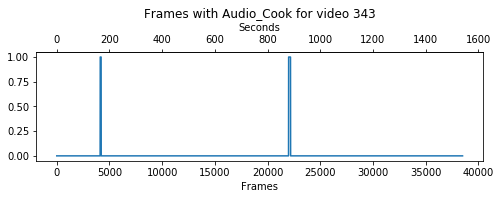

Video: 211
Number of frames: 38681
Number of frames with Audio_Cook: 1157
Length: 1547.24 seconds


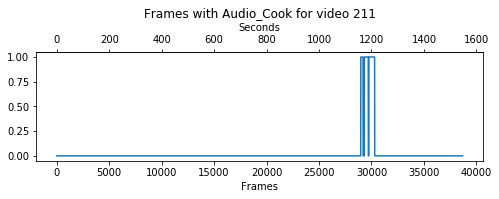

Video: 244
Number of frames: 38706
Number of frames with Audio_Cook: 0
Length: 1548.24 seconds


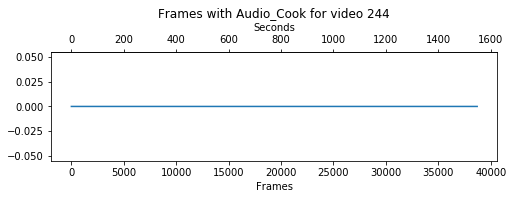

In [9]:
def show_gt_description(df, column="Audio_Cook", fps=25):
    print(f"Video: {df.loc[0, 'Video']}")
    print(f"Number of frames: {df['Frame_number'].count()}")
    print(
        f"Number of frames with {column}: {df.loc[df[column] == 1, 'Frame_number'].count()}"
    )
    print(f"Length: {len(df['Frame_number']) / fps} seconds")

    # plotting with frames and seconds as x-axis
    fig = plt.figure(figsize=(8, 2))
    ax1 = fig.add_subplot(111)
    ax1.set_title(f"Frames with {column} for video {df.loc[0, 'Video']}")
    ax1.set_xlabel("Frames")
    frame_indicator = np.zeros(len(df["Frame_number"]))
    frame_indicator[df[df[column] == 1].index] = 1
    ax1.plot(df[column].index, frame_indicator)

    def frames_to_sec(x):
        return x / fps

    def sec_to_frames(x):
        return x * fps

    ax2 = ax1.secondary_xaxis("top", functions=(frames_to_sec, sec_to_frames))
    ax2.set_xlabel("Seconds")
    plt.show()


show_gt_description(gts[0])
show_gt_description(gts[1])
show_gt_description(gts[2])

We can see that the swedish chef occurs only in the audio of video 343 and 211. In the next step, we will combine our ground truth dataframes into one, filter for the Audio_Cook column and add a column seconds to the data frame. 

## 1.4 Combine data frames, filter for Audio_Cook and add seconds

In [10]:
df_gt = pd.concat(gts)
df_gt["Seconds"] = df_gt["Frame_number"] / FPS
df_gt = df_gt[["Video", "Frame_number", "Seconds", "Audio_Cook"]]
df_gt.head()

,Video,Frame_number,Seconds,Audio_Cook
0,343,0,0.00,0
1,343,1,0.04,0
2,343,2,0.08,0
3,343,3,0.12,0
4,343,4,0.16,0


In the next step, we will convert the video files to wav format

## 1.5 Convert videos to wav

In [11]:
map_code_to_file = {211: "02-01-01", 244: "02-04-04", 343: "03-04-03"}

AUDIO_PATH = "../data/audio/"
os.makedirs(AUDIO_PATH, exist_ok=True)

for code in df_gt["Video"].unique():
    fname_in = f"Muppets-{map_code_to_file[code]}.avi"
    fname_out = f"Muppets-{map_code_to_file[code]}.wav"
    command2wav = f"ffmpeg -i {os.path.join(VIDEO_PATH, fname_in)} {os.path.join(AUDIO_PATH, fname_out)}"
    os.system(command2wav)

    df_gt.loc[
        df_gt["Video"] == code, "fname_audio"
    ] = fname_out  # save audio filename to data frame

    print(f"Converted {fname_in} to {fname_out}")

Converted Muppets-03-04-03.avi to Muppets-03-04-03.wav
Converted Muppets-02-01-01.avi to Muppets-02-01-01.wav
Converted Muppets-02-04-04.avi to Muppets-02-04-04.wav


## 1.6 Create Mel Spectrograms
We will now use the converted audio data to create Mel Spectrograms. The difficulty is that we have annotations on a frame level and we will later on test our models against this ground truth. Quite often, CNN-based audio classification models work with spectrogram snippets capturing around 1 second of the audio file. For our task, this would probably be not sufficient, as we need to predict on a much higher resolution (1 frame = 40ms). One approach is to use only a few samples and a even smaller hop length when calculating the spectrograms. Another approach would be to create lower resolution spectrograms, classify them and then use post-processing to approximate the frame-level annotations. In the beginning, we will focus on the first mentioned approach: 

With a sample rate of 16kHz, 1 frame (40 ms) equals to 640 audio samples.
We will use 320 samples as FFT window and a hop length of 160 samples. This transforms each frame (of 40 ms audio) to 4 spectrogram frames. We are using 4 spectrogram frames so that the CNN can at least use a little bit of temporal information (and not only 1 single spectrogram frame at a time). We will use 64 mel frequency bands as this showed good results in previous implementations.

S.shape =(64, 153946)


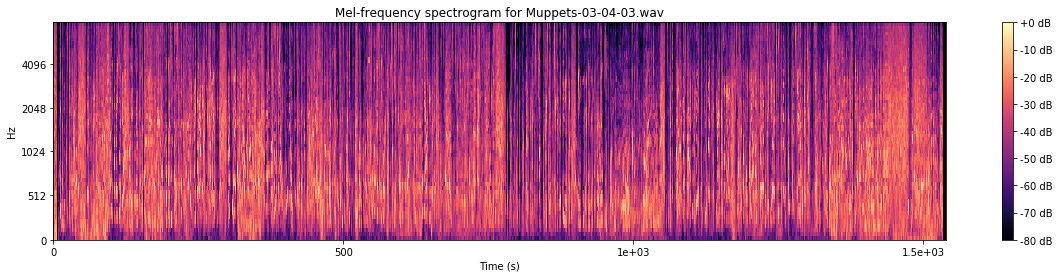

S.shape =(64, 154685)


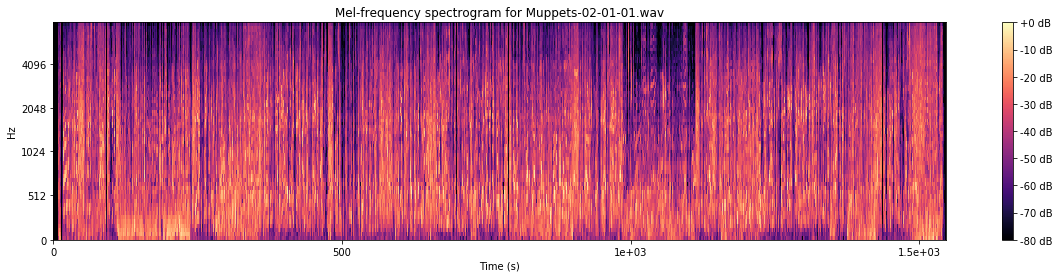

S.shape =(64, 154781)


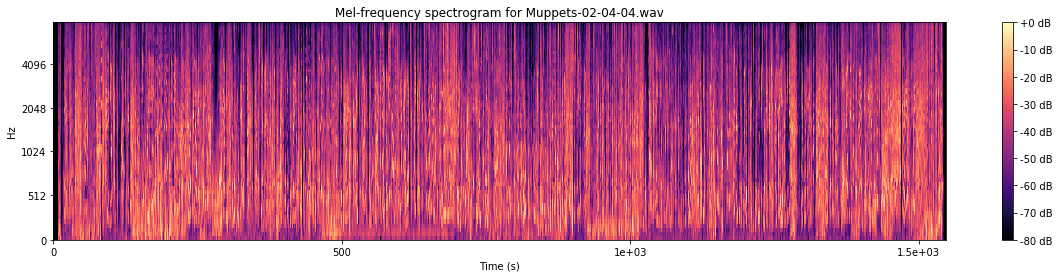

In [12]:
SR = 16000  # we will use a sample rate of 16kHz
N_FFT = 320  # = 20ms @ 16kHz
HOP_LENGTH = 160  # = 10ms @ 16kHz
N_MELS = 64

spectrograms = {}

for fname_audio in df_gt["fname_audio"].unique():
    y, sr = librosa.load(os.path.join(AUDIO_PATH, fname_audio), sr=SR)
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
    )
    print(f"{S.shape =}")
    spectrograms[fname_audio] = S

    fig, ax = plt.subplots(figsize=(20, 4))
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(
        S_dB,
        x_axis="s",
        y_axis="mel",
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        ax=ax,
    )
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    ax.set(title=f"Mel-frequency spectrogram for {fname_audio}")
    plt.show()

## 1.7 Create train, validation, test split
We will use 70% of the frames for training, 15% for validation and 15% for testing. We split in a stratified manner, to retain an equal distribution of the label across all data splits. 

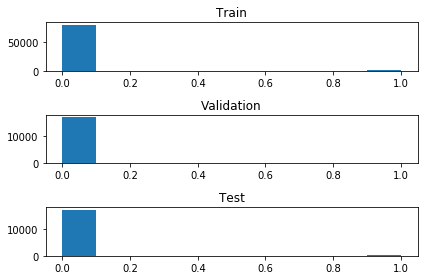

In [13]:
train, _val_test = train_test_split(
    df_gt, test_size=0.3, stratify=df_gt["Audio_Cook"], random_state=RANDOM_STATE
)

val, test = train_test_split(
    _val_test,
    test_size=0.5,
    stratify=_val_test["Audio_Cook"],
    random_state=RANDOM_STATE,
)

fig, axs = plt.subplots(3)
axs[0].hist(train["Audio_Cook"])
axs[0].set_title("Train")

axs[1].hist(val["Audio_Cook"])
axs[1].set_title("Validation")

axs[2].hist(test["Audio_Cook"])
axs[2].set_title("Test")

plt.tight_layout()
plt.show()

## 1.8 Create class weights
As our task boils down to an imbalanced classification problem, we will employ class weights. The class weights are calculated as the inverse class proportions in the training set.

In [14]:
cw_negative = len(train) / len(train[train["Audio_Cook"] == 0])
cw_positive = len(train) / len(train[train["Audio_Cook"] == 1])

print(f"Class weight Cook not present: {cw_negative}")
print(f"Class weight Cook present: {cw_positive}")

class_weights = {0: cw_negative, 1: cw_positive}

Class weight Cook not present: 1.0125951816252652
Class weight Cook present: 80.39544103072349


# Approach 1
Within this approach, we will test to use small spectrogram snippets consisting of 4 spectrogram frames which are equal to 1 video frame.

## 2.1 Create X, y arrays from spectrograms 
We will create X and y arrays, where X contains a 64x4 spectrogram snippet for each video frame and y the corresponding label.

In [15]:
def create_Xy_from_spectrograms_A1(
    df, spectrograms, stv_rate=4
):  # stv_rate = spectrogram to video frame rate ratio
    X = []
    y = []
    frame_unsuccesful = (
        []
    )  # in this array we will story frame + video for which we did not find spectrogram info
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        spec_slice_horizontal = slice(
            row["Frame_number"] * stv_rate, (row["Frame_number"] + 1) * stv_rate
        )
        spec = spectrograms[row["fname_audio"]]
        snippet = spec[:, spec_slice_horizontal]
        if snippet.shape[1] < 4:
            frame_unsuccesful.append(str(row["Video"]) + "_" + str(row["Frame_number"]))
        else:
            X.append(snippet)
            y.append(row["Audio_Cook"])
    X = np.dstack(X)
    X = np.swapaxes(X, 0, 2)
    X = np.swapaxes(X, 1, 2)
    X = np.expand_dims(X, axis=3)
    y = np.array(y)

    print(f"Created X array with shape {X.shape}")
    print(f"Created y array with shape {y.shape}")
    print(
        f"For {len(frame_unsuccesful)} video frames, we did not find a spectrogram frame"
    )

    return X, y, frame_unsuccesful


X_train_A1, y_train_A1, fu_train_A1 = create_Xy_from_spectrograms_A1(
    train, spectrograms
)
X_val_A1, y_val_A1, fu_val_A1 = create_Xy_from_spectrograms_A1(val, spectrograms)
X_test_A1, y_test_A1, fu_test_A1 = create_Xy_from_spectrograms_A1(test, spectrograms)


# Save snippets + labels to file
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
with open(os.path.join(PROCESSED_DATA_PATH, "X_train_audio_cook_A1.npy"), "wb") as f:
    np.save(f, X_train_A1, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "y_train_audio_cook_A1.npy"), "wb") as f:
    np.save(f, y_train_A1, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "X_val_audio_cook_A1.npy"), "wb") as f:
    np.save(f, X_val_A1, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "y_val_audio_cook_A1.npy"), "wb") as f:
    np.save(f, y_val_A1, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "X_test_audio_cook_A1.npy"), "wb") as f:
    np.save(f, X_test_A1, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "y_test_audio_cook_A1.npy"), "wb") as f:
    np.save(f, y_test_A1, allow_pickle=False)

100%|██████████| 81119/81119 [00:04<00:00, 20205.50it/s]


Created X array with shape (81095, 64, 4, 1)
Created y array with shape (81095,)
For 24 video frames, we did not find a spectrogram frame


100%|██████████| 17383/17383 [00:00<00:00, 20671.33it/s]


Created X array with shape (17377, 64, 4, 1)
Created y array with shape (17377,)
For 6 video frames, we did not find a spectrogram frame


100%|██████████| 17383/17383 [00:00<00:00, 20591.12it/s]


Created X array with shape (17380, 64, 4, 1)
Created y array with shape (17380,)
For 3 video frames, we did not find a spectrogram frame


For some of the video frames, we do not have spectrogram frames. This should be further investigated, but as it is only a very small number compared to the total number of frames, we will ignore this for now.

## 2.2 Load spectrogram snippets

In [16]:
if os.path.exists(PROCESSED_DATA_PATH):
    with open(
        os.path.join(PROCESSED_DATA_PATH, "X_train_audio_cook_A1.npy"), "rb"
    ) as f:
        X_train_A1 = np.load(f)
    with open(
        os.path.join(PROCESSED_DATA_PATH, "y_train_audio_cook_A1.npy"), "rb"
    ) as f:
        y_train_A1 = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "X_val_audio_cook_A1.npy"), "rb") as f:
        X_val_A1 = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "y_val_audio_cook_A1.npy"), "rb") as f:
        y_val_A1 = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "X_test_audio_cook_A1.npy"), "rb") as f:
        X_test_A1 = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "y_test_audio_cook_A1.npy"), "rb") as f:
        y_test_A1 = np.load(f)
    print("Loaded spectrogram snippets from disk!")

Loaded spectrogram snippets from disk!


## 2.3 Modeling

### 2.3.1 Standardize features
We will standardize the input features by subtracting the mean and dividing by the standard deviation of X_train. With that we end up with features having mean=0 and std=1.

In [17]:
xt_mean = X_train_A1.mean()
xt_std = X_train_A1.std()
print(f"Mean of X_train: {xt_mean}")
print(f"Std of X_train: {xt_std}")

X_train_A1 = (X_train_A1 - xt_mean) / xt_std
X_val_A1 = (X_val_A1 - xt_mean) / xt_std
X_test_A1 = (X_test_A1 - xt_mean) / xt_std

Mean of X_train: 0.00807117484509945
Std of X_train: 0.0433158241212368


### 2.3.2 Create datasets

In [18]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train_A1, y_train_A1))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val_A1, y_val_A1))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test_A1, y_test_A1))


BATCH_SIZE = 128
dataset_train = dataset_train.shuffle(buffer_size=1024).batch(BATCH_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE)
dataset_test = dataset_test.batch(BATCH_SIZE)

### 2.3.3 Define CNN model

In [19]:
input_shape = X_train_A1.shape[1:]
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation="relu", input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(250, activation="relu", kernel_regularizer="l2"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 2, 64)         640       
                                                                 
 batch_normalization (BatchN  (None, 62, 2, 64)        256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 1, 64)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1984)              0         
                                                                 
 dense (Dense)               (None, 250)               496250    
                                                                 
 batch_normalization_1 (Batc  (None, 250)              1

### 2.3.4 Compile and train CNN model

In [20]:
N_EPOCHS = 200

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.AUC(name="prc", curve="PR", num_thresholds=200),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision"),
    ],
)

history = model.fit(
    dataset_train,
    epochs=N_EPOCHS,
    class_weight=class_weights,
    validation_data=dataset_val,
    callbacks=[es_callback],
)

Epoch 1/200
634/634 [==============================] - 10s 8ms/step - loss: 2.8048 - prc: 0.0420 - recall: 0.6680 - precision: 0.0235 - val_loss: 1.3775 - val_prc: 0.0485 - val_recall: 0.8333 - val_precision: 0.0189
Epoch 2/200
634/634 [==============================] - 5s 7ms/step - loss: 1.7471 - prc: 0.0571 - recall: 0.6759 - precision: 0.0295 - val_loss: 1.1631 - val_prc: 0.0761 - val_recall: 0.8148 - val_precision: 0.0253
Epoch 3/200
634/634 [==============================] - 5s 8ms/step - loss: 1.5641 - prc: 0.0657 - recall: 0.7017 - precision: 0.0322 - val_loss: 0.9185 - val_prc: 0.0669 - val_recall: 0.6944 - val_precision: 0.0357
Epoch 4/200
634/634 [==============================] - 5s 7ms/step - loss: 1.4488 - prc: 0.0806 - recall: 0.7156 - precision: 0.0351 - val_loss: 0.9193 - val_prc: 0.1171 - val_recall: 0.8333 - val_precision: 0.0320
Epoch 5/200
634/634 [==============================] - 5s 7ms/step - loss: 1.4243 - prc: 0.0930 - recall: 0.7284 - precision: 0.0372 - val_

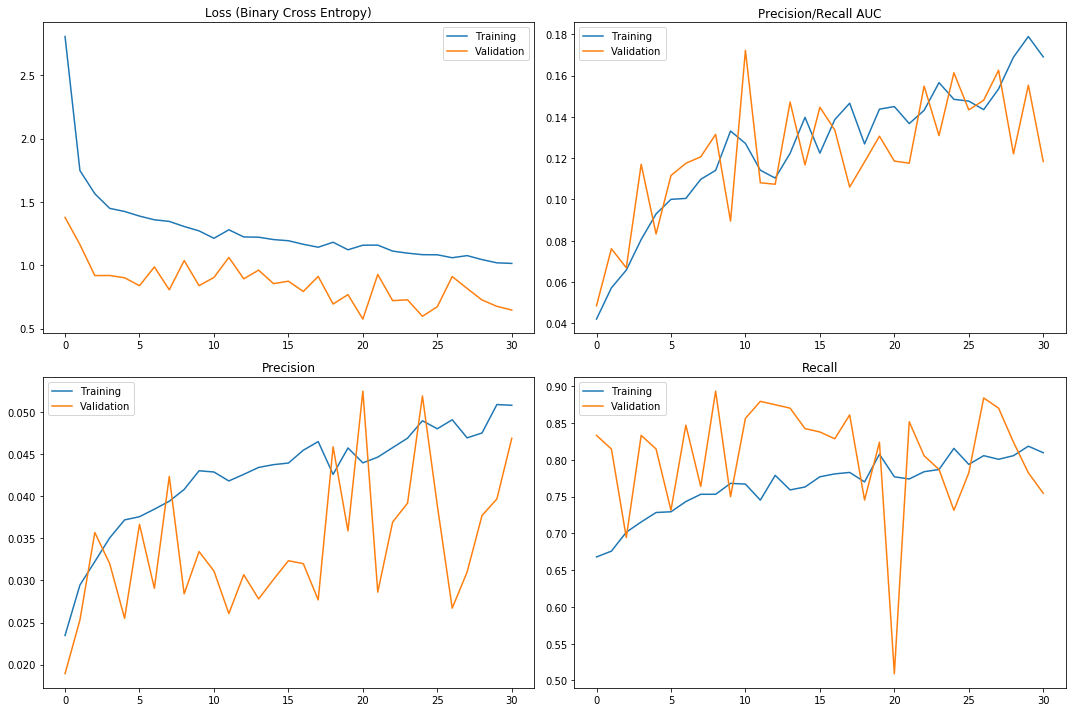

In [21]:
def plot_training_history(history):
    history = history.history
    epochs = np.arange(len(history["loss"]))

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs[0, 0].plot(epochs, history["loss"], label="Training")
    axs[0, 0].plot(epochs, history["val_loss"], label="Validation")
    axs[0, 0].set_title("Loss (Binary Cross Entropy)")
    axs[0, 0].legend()
    axs[0, 1].plot(epochs, history["prc"], label="Training")
    axs[0, 1].plot(epochs, history["val_prc"], label="Validation")
    axs[0, 1].set_title("Precision/Recall AUC")
    axs[0, 1].legend()

    axs[1, 0].plot(epochs, history["precision"], label="Training")
    axs[1, 0].plot(epochs, history["val_precision"], label="Validation")
    axs[1, 0].set_title("Precision")
    axs[1, 0].legend()

    axs[1, 1].plot(epochs, history["recall"], label="Training")
    axs[1, 1].plot(epochs, history["val_recall"], label="Validation")
    axs[1, 1].set_title("Recall")
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()


plot_training_history(history)

After experimenting with different CNN architectures, we conclude that our frame level spectrogram approach does not produce satisfactory results and that we have to come up with another strategy which uses bigger spectrogram snippets for model training and prediction.

# Approach 2
Withing this approach, we will test to use bigger spectrogram snippets. **We will use 4 video frames (16 spectrogram) before and after the 1 video frame (4 spectrogram frames) as classification context. This leads to a spectrogram snippet width of 16 + 4 + 16 = 36 spectrogram frames per class label.** We will use the label of the middle 4 spectrogram frames for training and classification. If we are at the beginning or the end of the spectrogram, we simple replace the missing frames with zeros.  

## 2.1 Create X, y arrays from spectrograms 
We will create X and y arrays, where X contains a 64x36 spectrogram snippet for each video frame and y the corresponding label. The 36 spectrogram frames consist of 4 spectrogram frames (1 video frame) in the middle together with 16 spectrogram frames (4 video frames) pre and appended as context for classification

In [22]:
def create_Xy_from_spectrograms_A2(df, spectrograms, stv_rate=4, context_size=16):
    # stv_rate = spectrogram to video frame rate ratio
    # context_size = number of spectrogram frames to pre and append to the label spectrogram frames
    X = []
    y = []
    frame_unsuccesful = (
        []
    )  # in this array we will story frame + video for which we did not find spectrogram info
    for idx, row in tqdm(df.iterrows(), total=len(df)):

        # find middle spectrogram frames corresponding to video frame label
        spec_slice_horizontal_label = slice(
            row["Frame_number"] * stv_rate, (row["Frame_number"] + 1) * stv_rate
        )
        spec = spectrograms[row["fname_audio"]]
        label_snippet = spec[:, spec_slice_horizontal_label]
        if label_snippet.shape[1] < 4:
            frame_unsuccesful.append(str(row["Video"]) + "_" + str(row["Frame_number"]))
        else:
            # create full snippet with context frames filled with zeros
            full_snippet = np.zeros((spec.shape[0], 2 * context_size + stv_rate))

            # place label snippet in the middle
            full_snippet[:, context_size : context_size + stv_rate] = label_snippet

            # find context
            # context_size frames before the actual frames
            context_pre = spec[
                :,
                row["Frame_number"] * stv_rate
                - context_size : row["Frame_number"] * stv_rate,
            ]
            # context_size frames after the actual frames
            context_post = spec[
                :,
                (row["Frame_number"] + 1)
                * stv_rate : (row["Frame_number"] + 1)
                * stv_rate
                + context_size,
            ]

            # place context in full snippet
            # fill from index context_size to left with context_pre
            full_snippet[
                :, context_size - context_pre.shape[1] : context_size
            ] = context_pre
            # fill after label frames with context_post
            full_snippet[
                :,
                context_size
                + stv_rate : context_size
                + stv_rate
                + context_post.shape[1],
            ] = context_post

            X.append(full_snippet)
            y.append(row["Audio_Cook"])
    X = np.dstack(X)
    X = np.swapaxes(X, 0, 2)
    X = np.swapaxes(X, 1, 2)
    X = np.expand_dims(X, axis=3)
    y = np.array(y)

    print(f"Created X array with shape {X.shape}")
    print(f"Created y array with shape {y.shape}")
    print(
        f"For {len(frame_unsuccesful)} video frames, we did not find a spectrogram frame"
    )

    return X, y, frame_unsuccesful


X_train_A2, y_train_A2, fu_train_A2 = create_Xy_from_spectrograms_A2(
    train, spectrograms
)
X_val_A2, y_val_A2, fu_val_A2 = create_Xy_from_spectrograms_A2(val, spectrograms)
X_test_A2, y_test_A2, fu_test_A2 = create_Xy_from_spectrograms_A2(test, spectrograms)


# Save snippets + labels to file
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
with open(os.path.join(PROCESSED_DATA_PATH, "X_train_audio_cook_A2.npy"), "wb") as f:
    np.save(f, X_train_A2, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "y_train_audio_cook_A2.npy"), "wb") as f:
    np.save(f, y_train_A2, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "X_val_audio_cook_A2.npy"), "wb") as f:
    np.save(f, X_val_A2, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "y_val_audio_cook_A2.npy"), "wb") as f:
    np.save(f, y_val_A2, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "X_test_audio_cook_A2.npy"), "wb") as f:
    np.save(f, X_test_A2, allow_pickle=False)
with open(os.path.join(PROCESSED_DATA_PATH, "y_test_audio_cook_A2.npy"), "wb") as f:
    np.save(f, y_test_A2, allow_pickle=False)

100%|██████████| 81119/81119 [00:07<00:00, 10780.39it/s]


Created X array with shape (81095, 64, 36, 1)
Created y array with shape (81095,)
For 24 video frames, we did not find a spectrogram frame


100%|██████████| 17383/17383 [00:01<00:00, 11998.76it/s]


Created X array with shape (17377, 64, 36, 1)
Created y array with shape (17377,)
For 6 video frames, we did not find a spectrogram frame


100%|██████████| 17383/17383 [00:01<00:00, 12328.18it/s]


Created X array with shape (17380, 64, 36, 1)
Created y array with shape (17380,)
For 3 video frames, we did not find a spectrogram frame


For some of the video frames, we do not have spectrogram frames. This should be further investigated, but as it is only a very small number compared to the total number of frames, we will ignore this for now.

## 2.2 Load spectrogram snippets

In [23]:
if os.path.exists(PROCESSED_DATA_PATH):
    with open(
        os.path.join(PROCESSED_DATA_PATH, "X_train_audio_cook_A2.npy"), "rb"
    ) as f:
        X_train_A2 = np.load(f)
    with open(
        os.path.join(PROCESSED_DATA_PATH, "y_train_audio_cook_A2.npy"), "rb"
    ) as f:
        y_train_A2 = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "X_val_audio_cook_A2.npy"), "rb") as f:
        X_val_A2 = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "y_val_audio_cook_A2.npy"), "rb") as f:
        y_val_A2 = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "X_test_audio_cook_A2.npy"), "rb") as f:
        X_test_A2 = np.load(f)
    with open(os.path.join(PROCESSED_DATA_PATH, "y_test_audio_cook_A2.npy"), "rb") as f:
        y_test_A2 = np.load(f)
    print("Loaded spectrogram snippets from disk!")

Loaded spectrogram snippets from disk!


## 2.3 Modeling

### 2.3.1 Standardize features
We will standardize the input features by subtracting the mean and dividing by the standard deviation of X_train. With that we end up with features having mean=0 and std=1.

In [24]:
xt_mean = X_train_A2.mean()
xt_std = X_train_A2.std()
print(f"Mean of X_train: {xt_mean}")
print(f"Std of X_train: {xt_std}")

X_train_A2 = (X_train_A2 - xt_mean) / xt_std
X_val_A2 = (X_val_A2 - xt_mean) / xt_std
X_test_A2 = (X_test_A2 - xt_mean) / xt_std

Mean of X_train: 0.008088953924055455
Std of X_train: 0.043443787544728746


### 2.3.2 Create datasets

In [25]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train_A2, y_train_A2))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val_A2, y_val_A2))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test_A2, y_test_A2))


BATCH_SIZE = 128
dataset_train = dataset_train.shuffle(buffer_size=1024).batch(BATCH_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE)
dataset_test = dataset_test.batch(BATCH_SIZE)

### 2.3.3 Define CNN model
We started with a very simple CNN model consisting of 1 Conv and 1 Dense layer and then keept adding layers until the results were satisfactory for us.

In [39]:
input_shape = X_train_A2.shape[1:]
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation="relu", input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(250, activation="relu", kernel_regularizer="l2"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 34, 64)        640       
                                                                 
 batch_normalization_6 (Batc  (None, 62, 34, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 17, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 15, 64)        36928     
                                                                 
 batch_normalization_7 (Batc  (None, 29, 15, 64)       256       
 hNormalization)                                                 
                                                      

### 2.3.4 Compile and train CNN model

In [40]:
if COLAB:
    checkpoint_filepath = os.path.join(root_path, "models", "audio-dl", "audio-dl")
else:
    checkpoint_filepath = "../models/audio-dl/audio-dl"

We use the validation loss as metric for early stopping of the model training and the PRAUC on the validation set as metric for model checkpointing. We decided to use the PRAUC, as its a nice way to summarize the tradeoff between Precision and Recall. Using the Fscore, would also be an valid alternative.

In [41]:
N_EPOCHS = 200

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="val_prc",
    mode="max",
    save_best_only=True,
)

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.AUC(name="prc", curve="PR", num_thresholds=200),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision"),
    ],
)

history = model.fit(
    dataset_train,
    epochs=N_EPOCHS,
    class_weight=class_weights,
    validation_data=dataset_val,
    callbacks=[es_callback, model_checkpoint_callback],
)

Epoch 1/200
634/634 [==============================] - 19s 27ms/step - loss: 2.7993 - prc: 0.0813 - recall: 0.7978 - precision: 0.0334 - val_loss: 1.0987 - val_prc: 0.1266 - val_recall: 0.5093 - val_precision: 0.1086
Epoch 2/200
634/634 [==============================] - 16s 26ms/step - loss: 1.3303 - prc: 0.2206 - recall: 0.8682 - precision: 0.0622 - val_loss: 4.8010 - val_prc: 0.0233 - val_recall: 0.9398 - val_precision: 0.0297
Epoch 3/200
634/634 [==============================] - 17s 27ms/step - loss: 1.0386 - prc: 0.2888 - recall: 0.8920 - precision: 0.0824 - val_loss: 0.5940 - val_prc: 0.2677 - val_recall: 0.8009 - val_precision: 0.1512
Epoch 4/200
634/634 [==============================] - 16s 26ms/step - loss: 0.7942 - prc: 0.4177 - recall: 0.9267 - precision: 0.1190 - val_loss: 0.6405 - val_prc: 0.2392 - val_recall: 0.8565 - val_precision: 0.1081
Epoch 5/200
634/634 [==============================] - 17s 26ms/step - loss: 0.7957 - prc: 0.4410 - recall: 0.9316 - precision: 0.12

### 2.3.5 Visualize training history

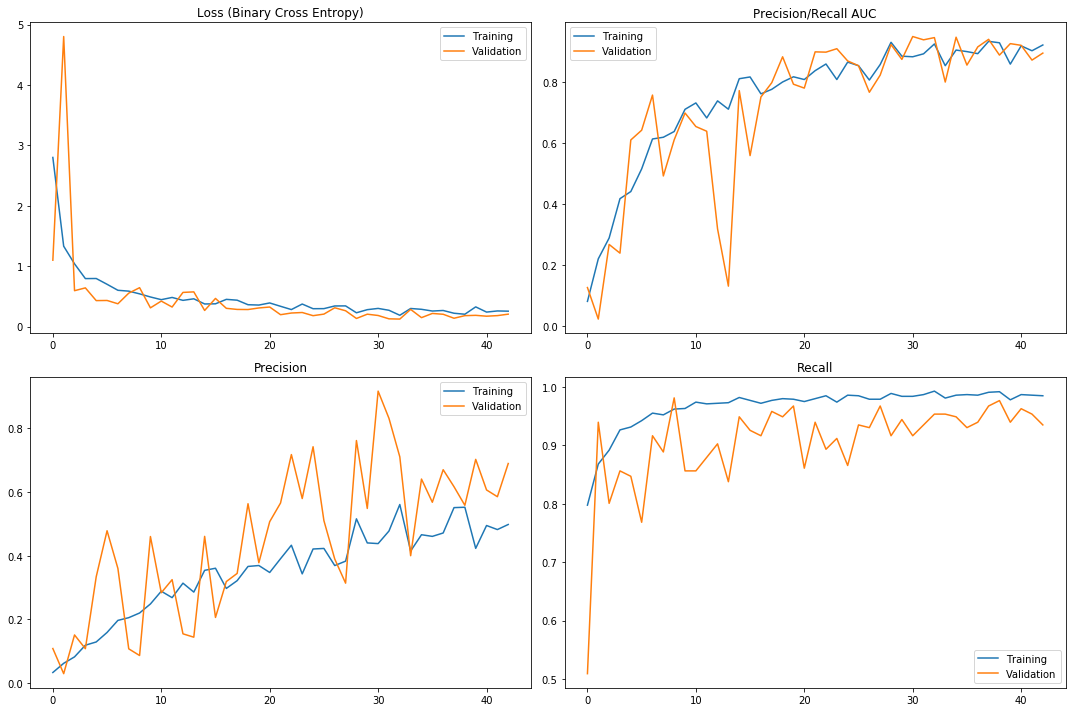

In [42]:
plot_training_history(history)

If we look at the loss curve, we can see that it is constantly minimized for training and validation data and the training process looks very satisfactory. We can observe that there is volatility for the PRAUC, but from Epoch 30 on, the values stabilize.
Also for the Precision, we can observe volatility for the validation set, but for some epochs, the Precision looks satisfactory. The Recall looks a lot less volatile. By storing the best model in regard to the PRAUC on the validation set, we want to get a model, where Precision and Recall are balanced and both have a rather high value. 

# 3. Evaluation


## 3.1 Load best model

In [43]:
status = model.load_weights(checkpoint_filepath)

## 3.2 Predict

In [44]:
# prediction
print("Predicting train data...")
y_hat_train = model.predict(X_train_A2)
print("Predicting val data...")
y_hat_val = model.predict(X_val_A2)
print("Predicting test data...")
y_hat_test = model.predict(X_test_A2)

Predicting train data...
2535/2535 [==============================] - 8s 3ms/step
Predicting val data...
544/544 [==============================] - 2s 3ms/step
Predicting test data...
544/544 [==============================] - 2s 3ms/step


## 3.3 Calculate PR curve for validation set and find optimal cutoff value
The ROC curve could also be used to find the optimal cutoff value, but as this lead to very unstable results, when using a different dataset split, we will stick to the PR curve for threshold estimation.

In [45]:
precision, recall, thresholds = precision_recall_curve(y_val_A2, y_hat_val)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
optimal_idx = np.argmax(fscore)
optimal_cutoff = thresholds[optimal_idx]
print(f"Found optimal cutoff threshold at {optimal_cutoff}")

Found optimal cutoff threshold at 0.6081188917160034


## 3.4 Show ROC curves



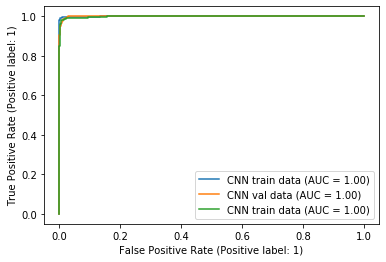

In [46]:
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(y_train_A2, y_hat_train, name="CNN train data", ax=ax)

RocCurveDisplay.from_predictions(y_val_A2, y_hat_val, name="CNN val data", ax=ax)

RocCurveDisplay.from_predictions(y_test_A2, y_hat_test, name="CNN train data", ax=ax)

plt.show()

We can see that the model scores a perfect AUC for all dataset splits. This seems almost too good to be true, but after repeatly checking the evaluation, we accept those results as valid. 

## 3.5 Discretize predictions to calculate further metrics

In [47]:
# discretize predictions
cutoff = optimal_cutoff

y_hat_train_discrete = y_hat_train.copy()
y_hat_train_discrete[y_hat_train_discrete < cutoff] = 0
y_hat_train_discrete[y_hat_train_discrete >= cutoff] = 1

y_hat_val_discrete = y_hat_val.copy()
y_hat_val_discrete[y_hat_val_discrete < cutoff] = 0
y_hat_val_discrete[y_hat_val_discrete >= cutoff] = 1

y_hat_test_discrete = y_hat_test.copy()
y_hat_test_discrete[y_hat_test_discrete < cutoff] = 0
y_hat_test_discrete[y_hat_test_discrete >= cutoff] = 1

## 3.6 Calculate metrics
We will calculate the Precision, Recall, Fscore and the AP over the train, validation, and test set.



In [48]:
# precision, recall, fscore
prf = {}
prf["train"] = precision_recall_fscore_support(
    y_train_A2, y_hat_train_discrete, average="binary"
)
prf["val"] = precision_recall_fscore_support(
    y_val_A2, y_hat_val_discrete, average="binary"
)
prf["test"] = precision_recall_fscore_support(
    y_test_A2, y_hat_test_discrete, average="binary"
)

# average precision
ap = {}
ap["train"] = average_precision_score(y_train_A2, y_hat_train_discrete)
ap["val"] = average_precision_score(y_val_A2, y_hat_val_discrete)
ap["test"] = average_precision_score(y_test_A2, y_hat_test_discrete)

## 3.7 Visualize Results

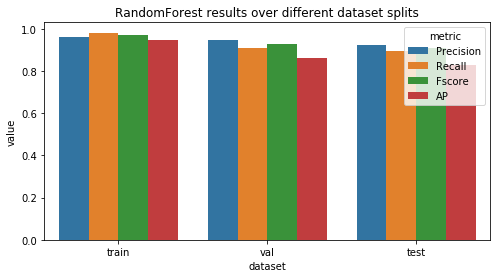

In [49]:
# make dataframe
res_holder = []
for ds in ["train", "val", "test"]:
    precision = {"dataset": ds, "metric": "Precision", "value": prf[ds][0]}
    recall = {"dataset": ds, "metric": "Recall", "value": prf[ds][1]}
    fscore = {"dataset": ds, "metric": "Fscore", "value": prf[ds][2]}
    avg_precision = {"dataset": ds, "metric": "AP", "value": ap[ds]}
    res_holder.append(precision)
    res_holder.append(recall)
    res_holder.append(fscore)
    res_holder.append(avg_precision)

res_df = pd.DataFrame(res_holder)

# plot
fig, ax = plt.subplots(figsize=(8, 4))
g = sns.barplot(data=res_df, x="dataset", y="value", hue="metric", ax=ax).set(
    title="RandomForest results over different dataset splits"
)
plt.show()

The metrics above also look almost perfect over all dataset splits. The metrics are only slightly lower for validation and testing compared to the training set. This is an indicator that the model is only slightly overfitting. As already mentioned for the video-based feature engineering approach, we have to keep in mind, that spectrogram snippets that are followed by each other (i.e., are very similar), can be in all of the 3 splits. To be really sure how good the model performs in the wild, video aware splitting or a new video solely for testing should be used.